In [1]:
# inline plotting

%matplotlib inline

In [142]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from statsmodels.graphics.tsaplots import plot_acf
from joblib import parallel_backend

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, RocCurveDisplay, roc_auc_score

from imblearn.under_sampling import RandomUnderSampler

import pickle
import mlflow
import seaborn as sns

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.model_selection import FeatureImportances

# Sleep States Prediction

## Course project

### Pipeline

### Read first dataset 

In [5]:
sleep_events = pd.read_csv("data/train_events.csv")

In [6]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [7]:
sleep_events.shape

(14508, 5)

In [8]:
sleep_events.describe().T

,count,mean,std,min,25%,50%,75%,max
night,14508.0,15.120072,10.286758,1.0,7.0,14.0,21.0,84.0
step,9585.0,214352.123944,141268.408192,936.0,95436.0,200604.0,317520.0,739392.0


In [9]:
# Count of uniqie series observations

np.count_nonzero(sleep_events.series_id.unique())

277

In [10]:
sleep_events.dtypes

series_id     object
night          int64
event         object
step         float64
timestamp     object
dtype: object

In [11]:
sleep_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


### Features extraction

In [12]:
sleep_events.step

0          4992.0
1         10932.0
2         20244.0
3         27492.0
4         39996.0
           ...   
14503    560604.0
14504    574620.0
14505    581604.0
14506         NaN
14507         NaN
Name: step, Length: 14508, dtype: float64

In [13]:
def plot_step(num_steps, steps):

    plt.plot(np.arange(0, num_steps), steps)

    plt.xlabel("time series")
    plt.ylabel("step")
    plt.semilogx()
    plt.semilogy()
    plt.show()

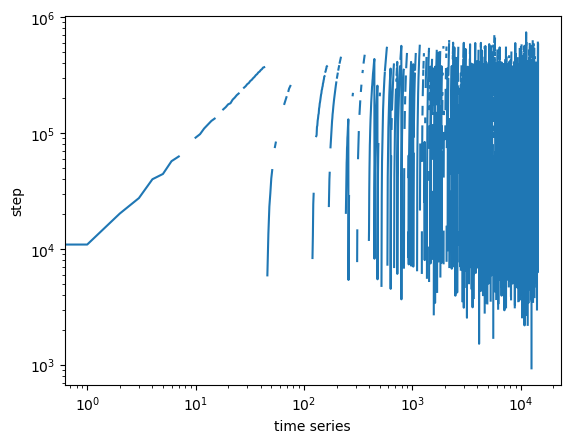

In [14]:
plot_step(len(sleep_events.step), sleep_events.step)

In [15]:
sleep_events["timestamp"] = sleep_events.timestamp.astype("datetime64[ns, UTC]")
sleep_events.timestamp

0       2018-08-15 02:26:00+00:00
1       2018-08-15 10:41:00+00:00
2       2018-08-15 23:37:00+00:00
3       2018-08-16 09:41:00+00:00
4       2018-08-17 03:03:00+00:00
                   ...           
14503   2017-09-06 08:07:00+00:00
14504   2017-09-07 03:35:00+00:00
14505   2017-09-07 13:17:00+00:00
14506                         NaT
14507                         NaT
Name: timestamp, Length: 14508, dtype: datetime64[ns, UTC]

In [16]:
# handle missing values in "timestamp"

sleep_events["timestamp"] = sleep_events["timestamp"].interpolate(Axis = 0)
sleep_events.timestamp

0       2018-08-15 02:26:00+00:00
1       2018-08-15 10:41:00+00:00
2       2018-08-15 23:37:00+00:00
3       2018-08-16 09:41:00+00:00
4       2018-08-17 03:03:00+00:00
                   ...           
14503   2017-09-06 08:07:00+00:00
14504   2017-09-07 03:35:00+00:00
14505   2017-09-07 13:17:00+00:00
14506   2017-09-07 13:17:00+00:00
14507   2017-09-07 13:17:00+00:00
Name: timestamp, Length: 14508, dtype: datetime64[ns, UTC]

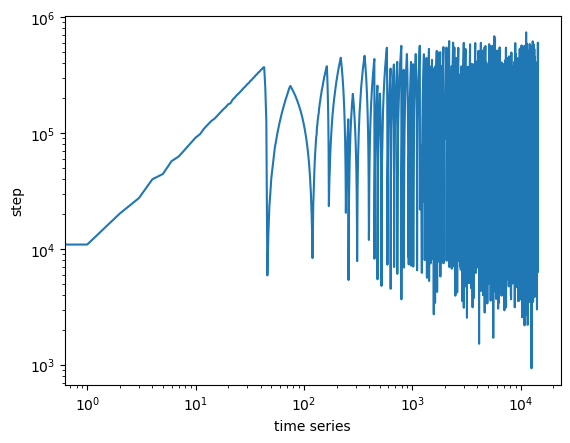

In [17]:
sleep_events["step"] = sleep_events.step.interpolate(Axis = 0)

plot_step(len(sleep_events.step), sleep_events.step)

In [18]:
sleep_events.dtypes

series_id                 object
night                      int64
event                     object
step                     float64
timestamp    datetime64[ns, UTC]
dtype: object

In [19]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-15 02:26:00+00:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 10:41:00+00:00
2,038441c925bb,2,onset,20244.0,2018-08-15 23:37:00+00:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 09:41:00+00:00
4,038441c925bb,3,onset,39996.0,2018-08-17 03:03:00+00:00


### Encoding

In [20]:
encoder = OrdinalEncoder()

# nd array
cat_features = list(zip(sleep_events.series_id, sleep_events.event))

# cat_features
cat_features_transformed = encoder.fit_transform(cat_features)

In [21]:
sleep_events["series_id"], sleep_events["event"] = cat_features_transformed[:, 0], cat_features_transformed[:, 1]

In [22]:
sleep_events.event.unique()

array([0., 1.])

In [23]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,0.0,1,0.0,4992.0,2018-08-15 02:26:00+00:00
1,0.0,1,1.0,10932.0,2018-08-15 10:41:00+00:00
2,0.0,2,0.0,20244.0,2018-08-15 23:37:00+00:00
3,0.0,2,1.0,27492.0,2018-08-16 09:41:00+00:00
4,0.0,3,0.0,39996.0,2018-08-17 03:03:00+00:00


#### Visualize autocorrelation 

In [24]:
sleep_events_indexed = sleep_events.set_index("timestamp")

In [25]:
sleep_events_indexed.index.min(), sleep_events_indexed.index.max()

(Timestamp('2017-08-06 02:44:00+0000', tz='UTC'),
 Timestamp('2019-07-05 09:33:00+0000', tz='UTC'))

In [26]:
def plot_autocorr(data, n_lags):
    plot_acf(data, lags = n_lags)
    
    plt.xlabel("n_lags")
    plt.ylabel("Percentage autocorr")
    plt.show()

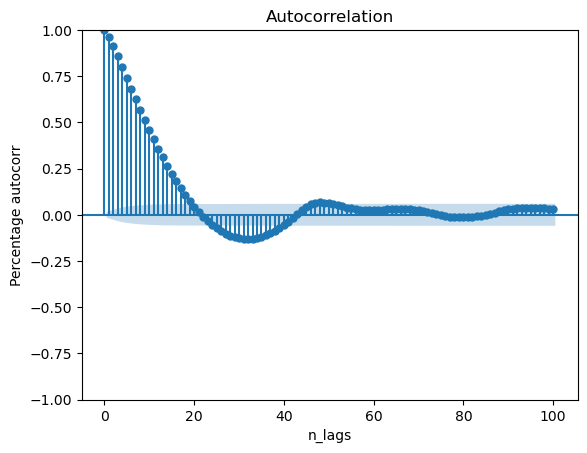

In [27]:
plot_autocorr(sleep_events_indexed.step, 100)

След определен момент автокорелацията става незначима (светлосинята област) - около 20 лага назад.

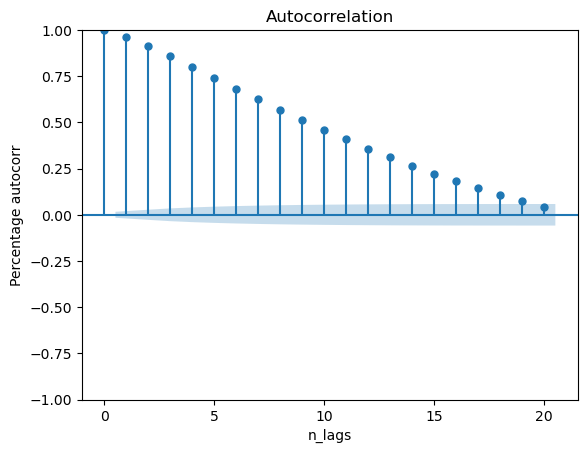

In [28]:
plot_autocorr(sleep_events_indexed.step, 20)

### Load second larger dataset

In [29]:
with parallel_backend("loky", n_jobs = 50):
    sleep_train = pd.read_parquet("data/train_series.parquet")

In [30]:
# sleep_train = pd.read_parquet("data/train_series.parquet")

In [31]:
sleep_train.dtypes

series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
dtype: object

In [32]:
sleep_train.shape

(127946340, 5)

In [33]:
sleep_train.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [34]:
# number of unique series

np.count_nonzero(sleep_train.series_id.unique())

277

#### Two tries to convert whole timestamp column as datetime format

In [33]:
# with parallel_backend("loky", n_jobs = 100):
#     sleep_train["timestamp"] = sleep_train.timestamp.astype("datetime64[ns, UTC]")

In [34]:
# sleep_train["time"] = sleep_train.timestamp.astype("datetime64[ns, UTC]").dt.hour

# sleep_train = sleep_train.drop(columns = "timestamp")

#### some features transformations

In [35]:
sleep_train["step"] = sleep_train.step.astype(float)

In [36]:
# convert series_id to float64.

series_ids = np.array(sleep_train.series_id).reshape(-1, 1)

series_ids = encoder.fit_transform(series_ids)

In [37]:
sleep_train["series_id"] = series_ids

In [38]:
sleep_train.dtypes

series_id    float64
step         float64
timestamp     object
anglez       float32
enmo         float32
dtype: object

In [39]:
sleep_train.head()

,series_id,step,timestamp,anglez,enmo
0,0.0,0.0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,0.0,1.0,2018-08-14T15:30:05-0400,2.6368,0.0215
2,0.0,2.0,2018-08-14T15:30:10-0400,2.6370,0.0216
3,0.0,3.0,2018-08-14T15:30:15-0400,2.6368,0.0213
4,0.0,4.0,2018-08-14T15:30:20-0400,2.6368,0.0215


In [45]:
sleep_train.timestamp.min()

'2017-08-04T17:30:00-0400'

In [46]:
sleep_train.timestamp.max()

'2019-07-09T09:44:55-0400'

### Merge train dataset with labels and useful features

In [40]:
# merge useful information 

with parallel_backend("loky", n_jobs = 200):
    sleep_train_labeled = pd.merge(sleep_train, sleep_events, how = "left", on = ["series_id", "step"], sort = False)

In [41]:
sleep_train_labeled.shape

(127946342, 8)

In [42]:
sleep_train_labeled.head()

,series_id,step,timestamp_x,anglez,enmo,night,event,timestamp_y
0,0.0,0.0,2018-08-14T15:30:00-0400,2.6367,0.0217,NaN,NaN,NaT
1,0.0,1.0,2018-08-14T15:30:05-0400,2.6368,0.0215,NaN,NaN,NaT
2,0.0,2.0,2018-08-14T15:30:10-0400,2.6370,0.0216,NaN,NaN,NaT
3,0.0,3.0,2018-08-14T15:30:15-0400,2.6368,0.0213,NaN,NaN,NaT
4,0.0,4.0,2018-08-14T15:30:20-0400,2.6368,0.0215,NaN,NaN,NaT


In [43]:
sleep_train_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946342 entries, 0 to 127946341
Data columns (total 8 columns):
 #   Column       Dtype              
---  ------       -----              
 0   series_id    float64            
 1   step         float64            
 2   timestamp_x  object             
 3   anglez       float32            
 4   enmo         float32            
 5   night        float64            
 6   event        float64            
 7   timestamp_y  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float32(2), float64(4), object(1)
memory usage: 6.7+ GB


In [44]:
sleep_train_labeled["event"] = sleep_train_labeled.event.fillna(-1)

sleep_train_labeled.event.unique()

array([-1.,  0.,  1.])

### Undersampling with shuffle = False

In [113]:
#count the classes

class_counts = sleep_train_lab.value_counts()
class_counts

event
-1.0    127935631
 1.0         5356
 0.0         5355
Name: count, dtype: int64

In [114]:
# find the minimum class counts

min_class_count = class_counts.min()
min_class_count

5355

In [115]:
# Resample each class to have an equal number of samples without shuffling

sleep_train_resampled = sleep_train_labeled.groupby("event", group_keys = False).apply(lambda x: x.head(min_class_count))
sleep_train_resampled.head()

,series_id,step,timestamp_x,anglez,enmo,night,event,timestamp_y
0,0.0,0.0,2018-08-14T15:30:00-0400,2.6367,0.0217,NaN,-1.0,NaT
1,0.0,1.0,2018-08-14T15:30:05-0400,2.6368,0.0215,NaN,-1.0,NaT
2,0.0,2.0,2018-08-14T15:30:10-0400,2.6370,0.0216,NaN,-1.0,NaT
3,0.0,3.0,2018-08-14T15:30:15-0400,2.6368,0.0213,NaN,-1.0,NaT
4,0.0,4.0,2018-08-14T15:30:20-0400,2.6368,0.0215,NaN,-1.0,NaT


In [116]:
sleep_train_resampled.event.value_counts()

event
-1.0    5355
 0.0    5355
 1.0    5355
Name: count, dtype: int64

In [117]:
sleep_train_att_resample = sleep_train_resampled.drop(columns = "event")

In [118]:
sleep_train_att_resample.shape

(16065, 7)

In [119]:
sleep_train_lab_resample = sleep_train_resampled.event

### Feature engeneering

In [120]:
sleep_train_att_resample["timestamp_x"] = sleep_train_att_resample.timestamp_x.astype("datetime64[ns, UTC]")

In [121]:
sleep_train_att_resample.dtypes

series_id                  float64
step                       float64
timestamp_x    datetime64[ns, UTC]
anglez                     float32
enmo                       float32
night                      float64
timestamp_y    datetime64[ns, UTC]
dtype: object

In [122]:
# Merge two columns timestamp in one

sleep_train_att_resample["timestamp"] = sleep_train_att_resample.timestamp_y.fillna(sleep_train_att_resample.timestamp_x)
sleep_train_att_resample = sleep_train_att_resample.drop(columns = ["timestamp_x", "timestamp_y"])
sleep_train_att_resample.head()

,series_id,step,anglez,enmo,night,timestamp
0,0.0,0.0,2.6367,0.0217,NaN,2018-08-14 19:30:00+00:00
1,0.0,1.0,2.6368,0.0215,NaN,2018-08-14 19:30:05+00:00
2,0.0,2.0,2.6370,0.0216,NaN,2018-08-14 19:30:10+00:00
3,0.0,3.0,2.6368,0.0213,NaN,2018-08-14 19:30:15+00:00
4,0.0,4.0,2.6368,0.0215,NaN,2018-08-14 19:30:20+00:00


#### Add higher order features

In [123]:
# Add columns date and hour

sleep_train_att_resample["date"] = sleep_train_att_resample.timestamp.dt.date
sleep_train_att_resample["hour"] = sleep_train_att_resample.timestamp.dt.hour

In [124]:
# add time delta and step delta between events

sleep_train_att_resample["step_diff"] = sleep_train_att_resample.groupby("series_id")["step"].diff()
sleep_train_att_resample["hour_diff"] = sleep_train_att_resample.groupby("series_id")["hour"].diff()
sleep_train_att_resample.head()

,series_id,step,anglez,enmo,night,timestamp,date,hour,step_diff,hour_diff
0,0.0,0.0,2.6367,0.0217,NaN,2018-08-14 19:30:00+00:00,2018-08-14,19,NaN,NaN
1,0.0,1.0,2.6368,0.0215,NaN,2018-08-14 19:30:05+00:00,2018-08-14,19,1.0,0.0
2,0.0,2.0,2.6370,0.0216,NaN,2018-08-14 19:30:10+00:00,2018-08-14,19,1.0,0.0
3,0.0,3.0,2.6368,0.0213,NaN,2018-08-14 19:30:15+00:00,2018-08-14,19,1.0,0.0
4,0.0,4.0,2.6368,0.0215,NaN,2018-08-14 19:30:20+00:00,2018-08-14,19,1.0,0.0


In [125]:
# working out the 24 hours substraction

hour_diff = [hour_diff + 24 if hour_diff < 0 else hour_diff for hour_diff in sleep_train_att_resample.hour_diff]
sleep_train_att_resample.hour_diff = hour_diff

In [126]:
# I need to fill na

sleep_train_att_resample = sleep_train_att_resample.fillna(0)
sleep_train_att_resample.head()

,series_id,step,anglez,enmo,night,timestamp,date,hour,step_diff,hour_diff
0,0.0,0.0,2.6367,0.0217,0.0,2018-08-14 19:30:00+00:00,2018-08-14,19,0.0,0.0
1,0.0,1.0,2.6368,0.0215,0.0,2018-08-14 19:30:05+00:00,2018-08-14,19,1.0,0.0
2,0.0,2.0,2.6370,0.0216,0.0,2018-08-14 19:30:10+00:00,2018-08-14,19,1.0,0.0
3,0.0,3.0,2.6368,0.0213,0.0,2018-08-14 19:30:15+00:00,2018-08-14,19,1.0,0.0
4,0.0,4.0,2.6368,0.0215,0.0,2018-08-14 19:30:20+00:00,2018-08-14,19,1.0,0.0


In [127]:
# "series_id" and "night" consist of high entropy, not a useful feature for the model

sleep_train_att_resample = sleep_train_att_resample.drop(columns = ["series_id", "night"])

In [128]:
sleep_train_att_resample.dtypes

step                     float64
anglez                   float32
enmo                     float32
timestamp    datetime64[ns, UTC]
date                      object
hour                       int32
step_diff                float64
hour_diff                float64
dtype: object

In [129]:
# change type ot column "date"

sleep_train_att_resample["date"] = pd.to_datetime(sleep_train_att_resample["date"])

In [130]:
sleep_train_att_resample.dtypes

step                     float64
anglez                   float32
enmo                     float32
timestamp    datetime64[ns, UTC]
date              datetime64[ns]
hour                       int32
step_diff                float64
hour_diff                float64
dtype: object

#### check variables "anglez" and "enmo" distributions

In [131]:
def show_distr(dataset, column, num_bins):

    plt.hist(dataset[column], alpha = 0.7)
    
    plt.semilogy()
    plt.xlabel("Value")
    plt.ylabel("Counts")
    plt.title(column)
    plt.show()

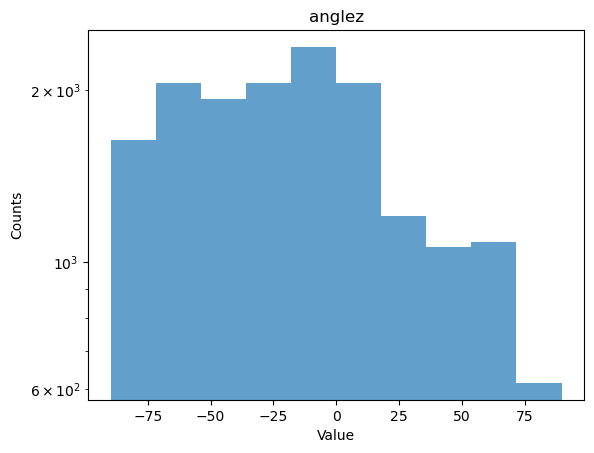

In [132]:
show_distr(sleep_train_att_resample, "anglez", "fd")

In [133]:
min_anglez, max_anglez = sleep_train_att_resample.anglez.min(), sleep_train_att_resample.anglez.max()

In [134]:
min_anglez, max_anglez

(-89.77680206298828, 89.7654037475586)

Anglez feature is with Gaussian distribution, so we will use standart scaling for its values.

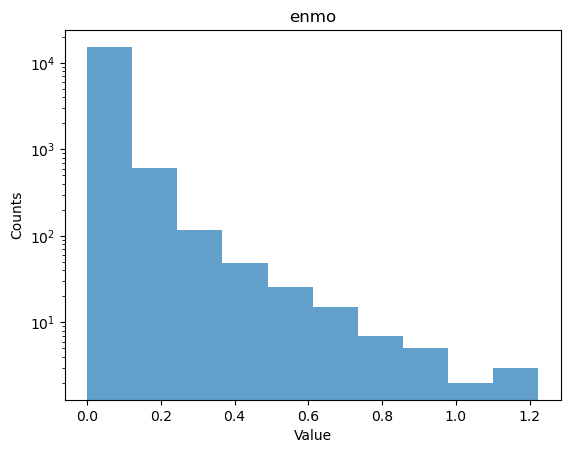

In [135]:
show_distr(sleep_train_att_resample, "enmo", "fd")

In [136]:
min_enmo, max_enmo = sleep_train_att_resample.enmo.min(), sleep_train_att_resample.enmo.max()

In [137]:
min_enmo, max_enmo

(0.0, 1.2232999801635742)

Enmo feature is with Exponential distribution, so we will use MinMax scaling for its values.

### Features Engeneering
#### Scaling the data

##### anglez with StandardScaler

In [138]:
std_scaler = StandardScaler()

In [139]:
anglez = np.array(sleep_train_att_resample.anglez).reshape(-1, 1)

In [140]:
std_scaler.fit(anglez)

StandardScaler()

In [141]:
anglez = std_scaler.transform(anglez)

In [142]:
anglez.min(), anglez.max(), anglez.mean(), anglez.std()

(-1.6881027, 2.2659771, 3.7992627e-09, 1.0)

##### all others with MinMaxScaler

In [143]:
mm_scaler = MinMaxScaler()

In [144]:
mm_features = np.array(sleep_train_att_resample.drop(columns = ["anglez", "timestamp", "date"]))

In [145]:
mm_scaler.fit(mm_features)

MinMaxScaler()

In [146]:
mm_features = mm_scaler.transform(mm_features)

In [147]:
col_names = ["step", "enmo", "hour", "step_diff", "hour_diff"]

In [148]:
sleep_train_att_resample = pd.DataFrame(mm_features)

In [149]:
sleep_train_att_resample.columns = col_names

In [150]:
sleep_train_att_resample["anglez"] = anglez

In [151]:
sleep_train_att_resample.head()

,step,enmo,hour,step_diff,hour_diff,anglez
0,0.000000,0.017739,0.826087,0.735031,0.0,0.347131
1,0.000001,0.017575,0.826087,0.735032,0.0,0.347133
2,0.000003,0.017657,0.826087,0.735032,0.0,0.347138
3,0.000004,0.017412,0.826087,0.735032,0.0,0.347133
4,0.000005,0.017575,0.826087,0.735032,0.0,0.347133


In [152]:
sleep_train_att_resample.shape

(16065, 6)

### Train and test split

In [229]:
sleep_attributes, sleep_labels = sleep_train_att_resample, sleep_train_lab_resample

In [230]:
sleep_attributes_train, sleep_attributes_test, sleep_labels_train, sleep_labels_test = train_test_split(sleep_attributes, sleep_labels, test_size = 0.2, random_state = 11)

### Pickle object serialization

#### save the train and test datasets with serialization

In [233]:
# with open("sleep_attributes_train.pkl", "wb") as f:   # open a pkl file
#     pickle.dump(sleep_attributes_train, f)            # serialize the trainset
# f.close

<function BufferedWriter.close>

In [234]:
# with open("sleep_attributes_test.pkl", "wb") as f:   # open a pkl file
#     pickle.dump(sleep_attributes_test, f)            # serialize the trainset
# f.close

<function BufferedWriter.close>

In [235]:
# with open("sleep_labels_train.pkl", "wb") as f:   # open a pkl file
#     pickle.dump(sleep_labels_train, f)            # serialize the testset
# f.close

<function BufferedWriter.close>

In [236]:
# with open("sleep_labels_test.pkl", "wb") as f:   # open a pkl file
#     pickle.dump(sleep_labels_test, f)            # serialize the testset
# f.close

<function BufferedWriter.close>

#### deserialize objects

In [3]:
# with open("sleep_attributes_train.pkl", "rb") as f:
#     sleep_attributes_train = pickle.load(f)
#     print()

In [5]:
# with open("sleep_labels_train.pkl", "rb") as f:
#     sleep_labels_train = pickle.load(f)
#     print()

In [6]:
# deserialize the file and print it

# with open("sleep_attributes_test.pkl", "rb") as f:
#     sleep_attributes_test = pickle.load(f)
#     print()

In [7]:
# deserialize the file and print it

# with open("sleep_labels_test.pkl", "rb") as f:
#     sleep_labels_test = pickle.load(f)
#     print()

### mlflow

In [ ]:
# experiment = mlflow.create_experiment(name = "P1_v3")

In [56]:
# mlflow.start_run()

<ActiveRun: >

In [238]:
# mlflow.log_artifact("P1_v3_serialized_objects/sleep_attributes_train.pkl")

In [239]:
# mlflow.log_artifact("P1_v3_serialized_objects/sleep_attributes_test.pkl")

In [240]:
# mlflow.log_artifact("P1_v3_serialized_objects/sleep_labels_train.pkl")

In [241]:
# mlflow.log_artifact("P1_v3_serialized_objects/sleep_labels_test.pkl")

In [248]:
# mlflow.log_param("test_size", 0.2)

0.2

In [249]:
# mlflow.log_param("shuffle_times", False)

False

In [65]:
# mlflow.end_run()

### Algorithm

### SVMs 
for 3 classes the alg trains three algorithms separately

3*(3-1)/2 = 6/2 = 3

#### Nu SVM rbf

In [48]:
nu_svm = NuSVC(kernel = "rbf", gamma = "scale", nu = 0.28, random_state = 11, probability = True)

In [64]:
# mlflow.log_param("support vectors", 6359)

6359

In [49]:
nu_svm.fit(sleep_attributes_train, sleep_labels_train)

NuSVC(nu=0.28, probability=True, random_state=11)

In [50]:
predictions = nu_svm.predict(sleep_attributes_test)

In [51]:
predictions_proba = nu_svm.predict_proba(sleep_attributes_test)

#### Evaluation metrics

In [52]:
nu_svm.score(sleep_attributes_train, sleep_labels_train)

0.921724245253657

In [250]:
# mlflow.log_metric("trainset score", 0.8564425770308123)

In [53]:
nu_svm.score(sleep_attributes_test, sleep_labels_test)

0.9299719887955182

In [253]:
# mlflow.log_metric("testset score", 0.8633675692499222)

In [44]:
len(nu_svm.support_vectors_)

6359

In [45]:
nu_svm.intercept_

array([0.80094885, 1.81321149, 0.86873577])

In [46]:
#Think if this brings any point?

MSE = mean_squared_error(sleep_labels_test, predictions)

In [47]:
np.sqrt(MSE)

0.3019801853905368

In [428]:
# mlflow.log_metric("sqrt_MSE", 0.4786119571636231)

In [93]:
# mlflow.end_run()

##### cross validation score

In [149]:
scores = cross_val_score(nu_svm, sleep_attributes_train, sleep_labels_train, cv = 5)
scores

array([0.92337612, 0.91793077, 0.92451362, 0.9233463 , 0.92023346])

#### Classification report

In [327]:
labels_names = ["no_event", "onset", "wakeup"]

In [333]:
print(classification_report(sleep_labels_test, predictions))

              precision    recall  f1-score   support

        -1.0       0.82      0.86      0.84      1087
         0.0       0.85      0.84      0.84      1079
         1.0       0.93      0.89      0.91      1047

    accuracy                           0.86      3213
   macro avg       0.87      0.86      0.86      3213
weighted avg       0.86      0.86      0.86      3213



#### Confusion Matrix

In [260]:
cm = confusion_matrix(sleep_labels_test, predictions)
cm

array([[937, 150,   0],
       [103, 901,  75],
       [ 99,  12, 936]], dtype=int64)

In [334]:
cm_df = pd.DataFrame(cm, index = labels_names, columns = labels_names)

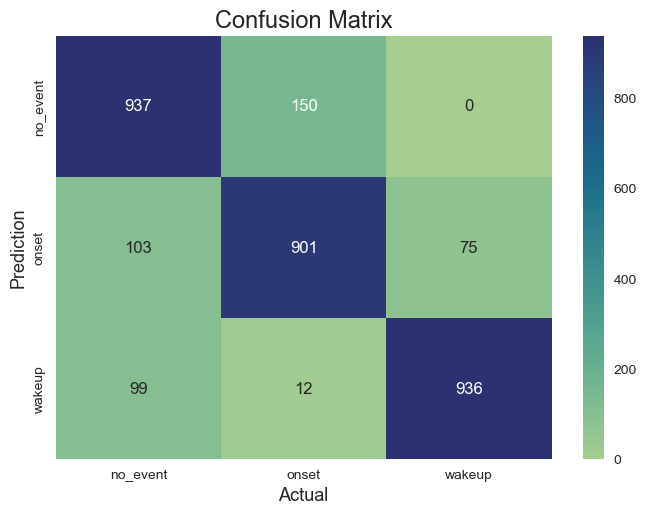

In [335]:
sns.heatmap(cm_df
            , annot = True
            , fmt = "g"
            , cmap = "crest"
           )
plt.ylabel("Prediction", fontsize = 13)
plt.xlabel("Actual", fontsize = 13)
plt.title("Confusion Matrix", fontsize = 17)
plt.show()

#### Classes histogram

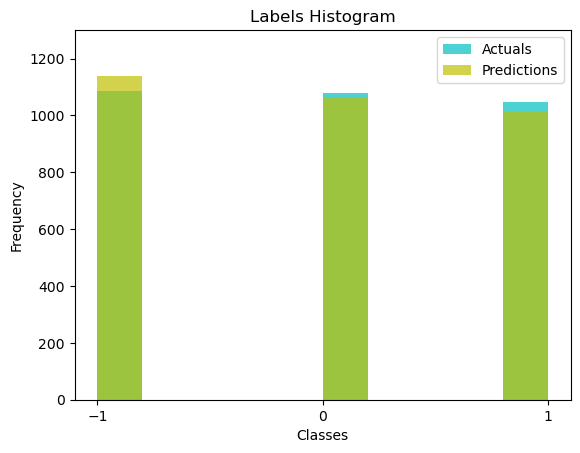

In [287]:
plt.hist(sleep_labels_test, color = "c", alpha = 0.7, label = "Actuals")
plt.hist(predictions, color = "y", alpha = 0.7, label = "Predictions")

plt.title("Labels Histogram")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks([-1, 0, 1])
plt.ylim(0, 1300)
plt.legend()
plt.show()

#### One-vs-one multiclass ROC

In [309]:
# This metric will help us evaluate different ROC curves

roc_auc_score = roc_auc_score(sleep_labels_test, predictions_proba, multi_class = "ovo")

print(f"ROC AUC: {roc_auc_score:.4f}")

ROC AUC: 0.9645


In [363]:
mlflow.log_param("roc_auc_score", 0.9645)

0.9645

#### visualize ROC curve
plot allows the user to visualize the tradeoff between the classifier’s sensitivity and specificity

In [358]:
# with yellowbrick

# visualizer = ROCAUC(nu_svm)

C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(


ROCAUC(ax=<Axes: >, estimator=NuSVC(probability=True, random_state=11))

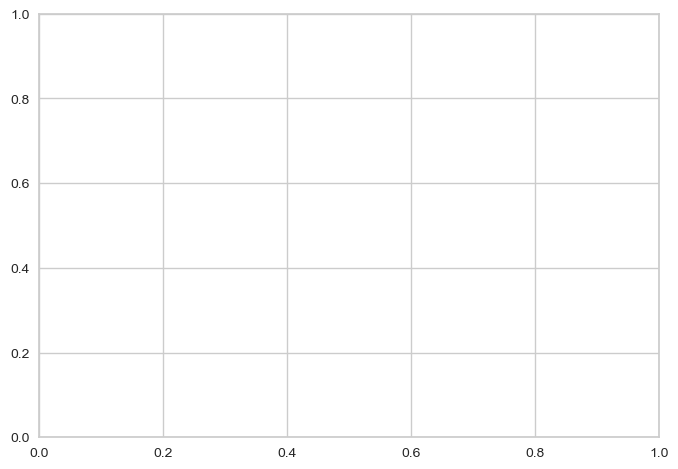

In [359]:
# visualizer.fit(sleep_attributes_train, sleep_labels_train)

In [346]:
# visualizer.score(sleep_attributes_test, sleep_labels_test)

0.9646936408370393

In [ ]:
# visualizer.show()

C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(


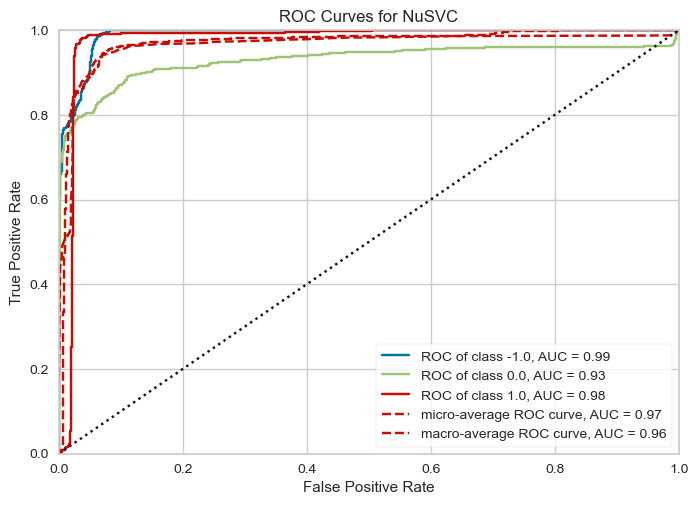

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for NuSVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=NuSVC(probability=True, random_state=11))

In [362]:
roc_auc(nu_svm, sleep_attributes_train, sleep_labels_train, X_test = sleep_attributes_test, y_test = sleep_labels_test)

#### linear svm

In [13]:
lin_svm = LinearSVC(C = 0.6,
                        # loss = ,
                       multi_class = "ovr",
                       dual = "auto",
                       random_state = 11)

In [14]:
lin_svm.fit(sleep_attributes_train, sleep_labels_train)

LinearSVC(C=0.6, dual='auto', random_state=11)

In [15]:
predictions_2 = lin_svm.predict(sleep_attributes_test)

In [16]:
lin_svm.score(sleep_attributes_train, sleep_labels_train)

0.9246031746031746

In [17]:
lin_svm.score(sleep_attributes_test, sleep_labels_test)

0.9299719887955182

In [18]:
lin_svm.coef_

array([[-1.91183102e+01,  9.74015917e-01,  2.05081753e-01,
        -5.21655405e-01, -7.42771156e+00, -3.24043957e-02],
       [ 1.23825035e+00,  2.15440476e+00, -2.35197279e+00,
         9.66841091e+00,  3.72406404e-01,  7.17591580e-04],
       [ 1.70341809e+00, -7.61265302e+00,  1.04484411e+00,
        -2.51934324e+00,  3.25821174e-01,  4.51400954e-02]])

In [33]:
# mlflow.create_experiment(name = "LinearSVM")
# mlflow.start_run()
mlflow.log_param("test_score", 0.929)

0.929

#### poly svm

In [478]:
poly_svm = SVC(C = 1, kernel = "poly", degree = 2, random_state = 11)

In [479]:
poly_svm.fit(sleep_attributes_train, sleep_labels_train)

SVC(C=1, degree=2, kernel='poly', random_state=11)

In [480]:
predictions_3 = poly_svm.predict(sleep_attributes_test)

In [481]:
poly_svm.score(sleep_attributes_train, sleep_labels_train)

0.9502801120448179

In [482]:
poly_svm.score(sleep_attributes_test, sleep_labels_test)

0.954248366013072

In [483]:
poly_svm.classes_

array([-1.,  0.,  1.])

In [484]:
poly_svm.class_weight_

array([1., 1., 1.])

In [486]:
poly_svm.dual_coef_

array([[ 1.,  1.,  1., ..., -0., -0., -0.],
       [ 0.,  1.,  0., ..., -1., -1., -1.]])

In [35]:
# add validation sets

### Try algorithm with trees

In [130]:
tree = DecisionTreeClassifier(criterion = "gini", splitter = "best", max_depth = 10, random_state = 11)

In [131]:
tree.fit(sleep_attributes_train, sleep_labels_train)

DecisionTreeClassifier(max_depth=10, random_state=11)

In [132]:
predictions_tree = tree.predict(sleep_attributes_test)

In [133]:
tree.feature_importances_

array([0.49931179, 0.00359717, 0.44930412, 0.02697946, 0.01737153,
       0.00343593])

In [134]:
permutation_importance(tree, sleep_attributes_train, sleep_labels_train)

{'importances_mean': array([0.44042951, 0.00477747, 0.31243386, 0.03485839, 0.01392779,
        0.00298786]),
 'importances_std': array([0.00390895, 0.00049358, 0.00217342, 0.00076078, 0.00054355,
        0.0004307 ]),
 'importances': array([[0.43557423, 0.43853097, 0.44273265, 0.44677871, 0.43853097],
        [0.00474634, 0.00427949, 0.00420168, 0.0052132 , 0.00544662],
        [0.31255836, 0.31084656, 0.30929038, 0.31528167, 0.31419234],
        [0.0340803 , 0.03392468, 0.03548086, 0.0358699 , 0.0349362 ],
        [0.01384998, 0.01338313, 0.01330532, 0.01447246, 0.01462807],
        [0.0026455 , 0.0026455 , 0.00381264, 0.00287893, 0.00295674]])}

In [135]:
tree.feature_names_in_

array(['step', 'enmo', 'hour', 'step_diff', 'hour_diff', 'anglez'],
      dtype=object)

In [136]:
tree.get_depth()

10

In [137]:
tree.score(sleep_attributes_train, sleep_labels_train)

0.9939309056956116

In [138]:
tree.score(sleep_attributes_test, sleep_labels_test)

0.9835045129162776

In [139]:
# mlflow.log_param("perm_f_importance", "first and third")

### load test set just to preview

In [ ]:
sleep_test = pd.read_parquet("data/test_series.parquet")

In [ ]:
sleep_test.head()

In [ ]:
sleep_test.shape

References:

    https://neptune.ai/blog/time-series-prediction-vs-machine-learning
    
    https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe
    
    https://ml-cheatsheet.readthedocs.io/en/latest/classification_algos.html?highlight=svm#support-vector-machine
    
    https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/#Confusion_Matrix_for_Multi-Class_Classification
    
    https://afioto.medium.com/classification-visualizations-with-yellowbrick-d6f6150d7a32
    
    https://www.freecodecamp.org/news/machine-learning-pipeline/#:~:text=There%20is%20a%20big%20difference,ColumnTransformer%20that%20you%20should%20understand.&text=You%20use%20the%20pipeline%20for,separately%20before%20combining%20them%20later.